In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%run 'functions.py'

In [3]:
total_usage_2012 = pd.read_parquet('../data/total_usage_2012.gzip')
total_usage_2013 = pd.read_parquet('../data/total_usage_2013.gzip')
# total_usage_2014 = pd.read_parquet('../data/total_usage_2014.gzip')

In [4]:
tariffs = pd.read_parquet('../data/tariffs.gzip')

lows = np.array(tariffs.index[tariffs['tariff'] == 'Low'], dtype=np.datetime64)
normals = np.array(tariffs.index[tariffs['tariff'] == 'Normal'], dtype=np.datetime64)
highs = np.array(tariffs.index[tariffs['tariff'] == 'High'], dtype=np.datetime64)

lows_2012 = lows - np.timedelta64(365, 'D')
normals_2012 = normals - np.timedelta64(365, 'D')
highs_2012 = highs - np.timedelta64(365, 'D')

In [7]:
# include a p/kWh & p/hh column that includes the price for that hh
total_usage_2012['p/kWh'] = 14.228
total_usage_2012['p/hh'] = total_usage_2012['KWH/hh'] * total_usage_2012['p/kWh']

total_usage_2013.loc[total_usage_2013['treated'], 'p/kWh'] = tariffs.loc[total_usage_2013.loc[total_usage_2013['treated'], 'date_time'], 'p/kWh'].values
total_usage_2013.loc[~total_usage_2013['treated'], 'p/kWh'] = 14.228
total_usage_2013['p/hh'] = total_usage_2013['KWH/hh'] * total_usage_2013['p/kWh']

In [5]:
total_acorn = pd.read_parquet('../data/total_acorn.gzip')

affluent = total_acorn.loc[total_acorn['acorn_category'] == 'Affluent']['house_id']
comfortable = total_acorn.loc[total_acorn['acorn_category'] == 'Comfortable']['house_id']
adversity = total_acorn.loc[total_acorn['acorn_category'] == 'Adversity']['house_id']

In [6]:
slice_2012_c = total_usage_2012.loc[(total_usage_2012['date_time'].dt.normalize() >= '2012-07-01') & (~total_usage_2012['treated'])]
slice_2013_c = total_usage_2013.loc[(total_usage_2013['date_time'].dt.normalize() >= '2013-07-01') & (~total_usage_2013['treated'])]

In [7]:
slice_2012_t = total_usage_2012.loc[(total_usage_2012['date_time'].dt.normalize() >= '2012-07-01') & (total_usage_2012['treated'])]
slice_2013_t = total_usage_2013.loc[(total_usage_2013['date_time'].dt.normalize() >= '2013-07-01') & (total_usage_2013['treated'])]

In [11]:
a1_dropped, b1_dropped, a2_dropped, b2_dropped = get_matrices_dropped(slice_2012_t, slice_2012_c, slice_2013_t, slice_2013_c, 0)

before anything (8832, 4428) (8832, 1116) (8832, 4253) (8832, 1093)
after cleaning (8832, 1332) (8832, 352) (8832, 1665) (8832, 443)
after house intersection (8832, 570) (8832, 168) (8832, 570) (8832, 168)


In [12]:
a1_dropped_inv = np.linalg.pinv(a1_dropped)
X = a1_dropped_inv @ b1_dropped.to_numpy()
b2_dropped_est_ = a2_dropped.to_numpy() @ X

b2_dropped_est = pd.DataFrame(b2_dropped_est_, columns=b2_dropped.columns, index=b2_dropped.index)

In [8]:
a1_imputed, b1_imputed, a2_imputed, b2_imputed = get_matrices_imputed(slice_2012_t, slice_2012_c, slice_2013_t, slice_2013_c)

before anything (8832, 4428) (8832, 1116) (8832, 4253) (8832, 1093)
after imputation (8832, 4428) (8832, 1116) (8832, 4253) (8832, 1093)
after house intersection (8832, 4246) (8832, 1088) (8832, 4246) (8832, 1088)


In [9]:
a1_imputed_inv = np.linalg.pinv(a1_imputed)
X = a1_imputed_inv @ b1_imputed.to_numpy()
b2_imputed_est_ = a2_imputed.to_numpy() @ X

b2_imputed_est = pd.DataFrame(b2_imputed_est_, columns=b2_imputed.columns, index=b2_imputed.index)

In [16]:
print('difference first, mean error:', (b2_imputed - b2_imputed_est).mean(axis=1).mean())
print('difference first, mean percent error:', ((b2_imputed - b2_imputed_est)/b2_imputed*100).mean(axis=1).mean())
print('mean first, mean error:', (b2_imputed.mean(axis=1) - b2_imputed_est.mean(axis=1)).mean())
print('mean first, mean percent error:', ((b2_imputed.mean(axis=1) - b2_imputed_est.mean(axis=1))/b2_imputed.mean(axis=1)*100).mean())

difference first, mean error: -0.010391663165029062
difference first, mean percent error: -inf
mean first, mean error: -0.010391663165029064
mean first, mean percent error: -5.683878917017437


In [17]:
print('difference first, mean error:', (b2_dropped - b2_dropped_est).mean(axis=1).mean())
print('difference first, mean percent error:', ((b2_dropped - b2_dropped_est)/b2_dropped*100).mean(axis=1).mean())
print('mean first, mean error:', (b2_dropped.mean(axis=1) - b2_dropped_est.mean(axis=1)).mean())
print('mean first, mean percent error:', ((b2_dropped.mean(axis=1) - b2_dropped_est.mean(axis=1))/b2_dropped.mean(axis=1)*100).mean())

difference first, mean error: -0.0006175616317190875
difference first, mean percent error: nan
mean first, mean error: -0.0006175616317190866
mean first, mean percent error: -0.9737095135578335


In [18]:
unique_house_per_hh_2012_c = unique_house_per_hh(slice_2012_c)
unique_house_per_hh_2013_c = unique_house_per_hh(slice_2013_c)

unique_house_per_hh_2012_t = unique_house_per_hh(slice_2012_t)
unique_house_per_hh_2013_t = unique_house_per_hh(slice_2013_t)

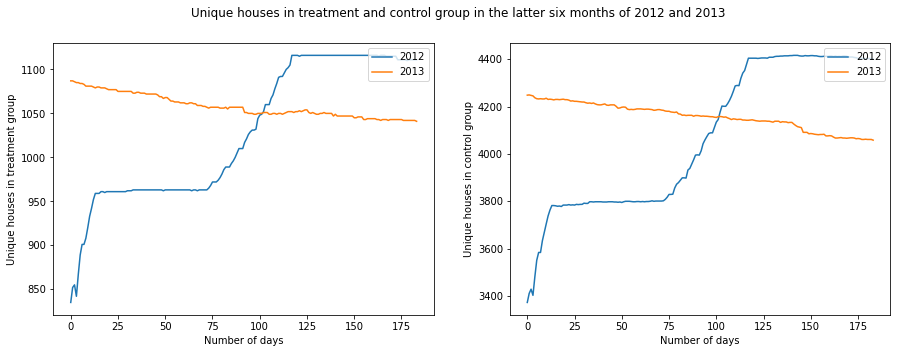

In [38]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
fig.suptitle('Unique houses in treatment and control group in the latter six months of 2012 and 2013')

ax[0].plot(unique_house_per_hh_2012_t.values, label='2012')
ax[0].plot(unique_house_per_hh_2013_t.values, label='2013')
ax[0].set_ylabel('Unique houses in treatment group')
ax[0].set_xlabel('Number of days')
ax[0].legend(loc=1)

ax[1].plot(unique_house_per_hh_2012_c.values, label='2012')
ax[1].plot(unique_house_per_hh_2013_c.values, label='2013')
ax[1].set_ylabel('Unique houses in control group')
ax[1].set_xlabel('Number of days')
plt.legend(loc=1);
# plt.savefig('../figs/unique_houses_second_six_months.png');

In [10]:
ME_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity', 'Overall'], columns=['Low', 'Normal', 'High', 'Overall'])
MPE_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity', 'Overall'], columns=['Low', 'Normal', 'High', 'Overall'])

In [11]:
b2 = b2_imputed
b2_est = b2_imputed_est

# b2 = b2_dropped
# b2_est = b2_dropped_est

In [12]:
ME_consumption.loc['Affluent', 'Low'], MPE_consumption.loc['Affluent', 'Low'] = get_subset(b2, b2_est, lows, affluent)

ME_consumption.loc['Affluent', 'Normal'], MPE_consumption.loc['Affluent', 'Normal'] = get_subset(b2, b2_est, normals, affluent)

ME_consumption.loc['Affluent', 'High'], MPE_consumption.loc['Affluent', 'High'] = get_subset(b2, b2_est, highs, affluent)

ME_consumption.loc['Affluent', 'Overall'], MPE_consumption.loc['Affluent', 'Overall'] = get_subset(b2, b2_est, b2.index, affluent)

ME_consumption.loc['Comfortable', 'Low'], MPE_consumption.loc['Comfortable', 'Low'] = get_subset(b2, b2_est, lows, comfortable)

ME_consumption.loc['Comfortable', 'Normal'], MPE_consumption.loc['Comfortable', 'Normal'] = get_subset(b2, b2_est, normals, comfortable)

ME_consumption.loc['Comfortable', 'High'], MPE_consumption.loc['Comfortable', 'High'] = get_subset(b2, b2_est, highs, comfortable)

ME_consumption.loc['Comfortable', 'Overall'], MPE_consumption.loc['Comfortable', 'Overall'] = get_subset(b2, b2_est, b2.index, comfortable)

ME_consumption.loc['Adversity', 'Low'], MPE_consumption.loc['Adversity', 'Low'] = get_subset(b2, b2_est, lows, adversity)

ME_consumption.loc['Adversity', 'Normal'], MPE_consumption.loc['Adversity', 'Normal'] = get_subset(b2, b2_est, normals, adversity)

ME_consumption.loc['Adversity', 'High'], MPE_consumption.loc['Adversity', 'High'] = get_subset(b2, b2_est, highs, adversity)

ME_consumption.loc['Adversity', 'Overall'], MPE_consumption.loc['Adversity', 'Overall'] = get_subset(b2, b2_est, b2.index, adversity)

ME_consumption.loc['Overall', 'Low'], MPE_consumption.loc['Overall', 'Low'] = get_subset(b2, b2_est, lows, b2.columns)

ME_consumption.loc['Overall', 'Normal'], MPE_consumption.loc['Overall', 'Normal'] = get_subset(b2, b2_est, normals, b2.columns)

ME_consumption.loc['Overall', 'High'], MPE_consumption.loc['Overall', 'High'] = get_subset(b2, b2_est, highs, b2.columns)

ME_consumption.loc['Overall', 'Overall'], MPE_consumption.loc['Overall', 'Overall'] = get_subset(b2, b2_est, b2.index, b2.columns)

In [65]:
# b2_normal_affluent = b2.loc[b2.index.isin(normals), b2.columns.isin(affluent)]
# b2_est_normal_affluent = b2_est.loc[b2_est.index.isin(normals), b2_est.columns.isin(affluent)]
# print((b2_normal_affluent - b2_est_normal_affluent).mean().mean() / b2_est_normal_affluent.mean().mean())

# b2_normal_comfortable = b2.loc[b2.index.isin(normals), b2.columns.isin(comfortable)]
# b2_est_normal_comfortable = b2_est.loc[b2_est.index.isin(normals), b2_est.columns.isin(comfortable)]
# print((b2_normal_comfortable - b2_est_normal_comfortable).mean().mean() / b2_est_normal_comfortable.mean().mean())

# b2_normal_adversity = b2.loc[b2.index.isin(normals), b2.columns.isin(adversity)]
# b2_est_normal_adversity = b2_est.loc[b2_est.index.isin(normals), b2_est.columns.isin(adversity)]
# print((b2_normal_adversity - b2_est_normal_adversity).mean().mean() / b2_est_normal_adversity.mean().mean())


# b2_low_affluent = b2.loc[b2.index.isin(lows), b2.columns.isin(affluent)]
# b2_est_low_affluent = b2_est.loc[b2_est.index.isin(lows), b2_est.columns.isin(affluent)]
# print((b2_low_affluent - b2_est_low_affluent).mean().mean() / b2_low_affluent.mean().mean())

# b2_low_comfortable = b2.loc[b2.index.isin(lows), b2.columns.isin(comfortable)]
# b2_est_low_comfortable = b2_est.loc[b2_est.index.isin(lows), b2_est.columns.isin(comfortable)]
# print((b2_low_comfortable - b2_est_low_comfortable).mean().mean() / b2_low_comfortable.mean().mean())

# b2_low_adversity = b2.loc[b2.index.isin(lows), b2.columns.isin(adversity)]
# b2_est_low_adversity = b2_est.loc[b2_est.index.isin(lows), b2_est.columns.isin(adversity)]
# print((b2_low_adversity - b2_est_low_adversity).mean().mean() / b2_low_adversity.mean().mean())

In [13]:
ME_imputed_consumption = ME_consumption
MPE_imputed_consumption = MPE_consumption

# ME_dropped_consumption = ME_consumption
# MPE_dropped_consumption = MPE_consumption

In [69]:
# ME_imputed_consumption.to_csv('~/Downloads/ME_imputed_consumption.csv')
# MPE_imputed_consumption.to_csv('~/Downloads/MPE_imputed_consumption.csv')
# ME_dropped_consumption.to_csv('~/Downloads/ME_dropped_consumption.csv')
# MPE_dropped_consumption.to_csv('~/Downloads/MPE_dropped_consumption.csv')

In [15]:
ME_imputed_consumption = ME_imputed_consumption.astype(float)
MPE_imputed_consumption = MPE_imputed_consumption.astype(float)
# ME_dropped_consumption = ME_dropped_consumption.astype(float)
# MPE_dropped_consumption = MPE_dropped_consumption.astype(float)

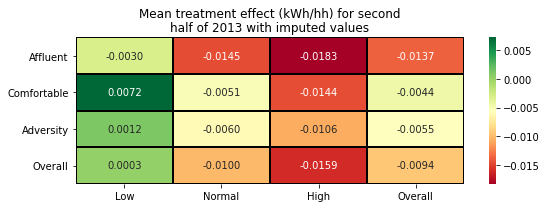

In [16]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(ME_imputed_consumption, annot=True, fmt='.4f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax)
ax.set_title(r'Mean treatment effect (kWh/hh) for second'
             '\n'
             r'half of 2013 with imputed values')
plt.tight_layout()
plt.savefig('../figs/ME_imputed_consumption.png')

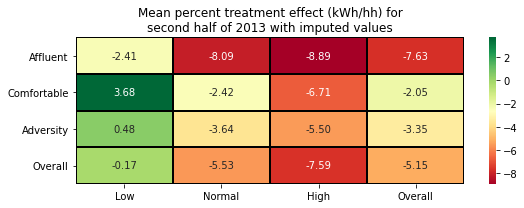

In [17]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(MPE_imputed_consumption, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax)
ax.set_title(r'Mean percent treatment effect (kWh/hh) for'
             '\n'
             r'second half of 2013 with imputed values')
plt.tight_layout()
plt.savefig('../figs/MPE_imputed_consumption.png')

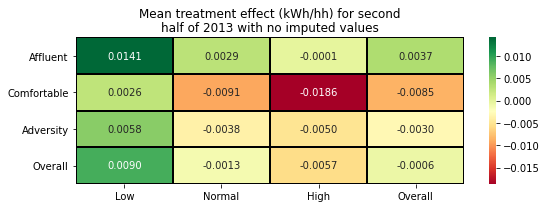

In [173]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(ME_dropped_consumption, annot=True, fmt='.4f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax)
ax.set_title(r'Mean treatment effect (kWh/hh) for second'
             '\n'
             r'half of 2013 with no imputed values')
plt.tight_layout()
plt.savefig('../figs/ME_dropped_consumption.png')

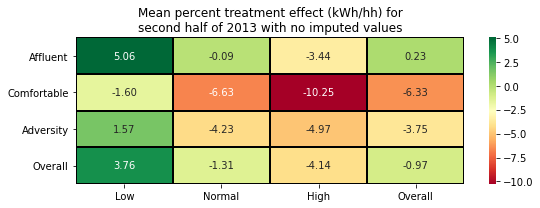

In [175]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(MPE_dropped_consumption, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax)
ax.set_title(r'Mean percent treatment effect (kWh/hh) for'
             '\n'
             r'second half of 2013 with no imputed values')
plt.tight_layout()
plt.savefig('../figs/MPE_dropped_consumption.png')

In [176]:
# MPE_dropped_consumption.style.background_gradient(cmap='RdYlGn')
# MPE_imputed_consumption.style.background_gradient(cmap='YlGnBu')

- https://stackoverflow.com/questions/42712304/seaborn-heatmap-subplots-keep-axis-ratio-consistent
- https://stackoverflow.com/questions/43073971/control-individual-linewidths-in-seaborn-heatmap